<a href="https://colab.research.google.com/github/Gilmer007/proyecto/blob/master/MiVivienda_Prediction_Part2_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install eli5

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [ ]:
#data = pd.read_csv("MiVivienda_Ready1_.csv")
data = pd.read_csv("MiVivienda_Ready1_70k.csv")
print("Datos cargados. Dimensiones:", data.shape)
data

Datos cargados. Dimensiones: (76936, 7)


,MONTO_CREDITO,MONTO_VALOR_VIVIENDA,PLAZOS,PRODUCTO,TASA,MONTO_CUOTA_INICIAL,segmento_economico_2
0,29800.00,68000.0,120.0,FCTP,14.50,6800.00,1
1,42500.00,65000.0,120.0,NCMV,13.50,6500.00,1
2,37350.00,77500.0,96.0,FCTP,14.00,7750.00,1
3,32450.00,79000.0,96.0,FCTP,14.00,14150.00,1
4,37650.01,79000.0,180.0,FCTP,14.00,8949.99,1
...,...,...,...,...,...,...,...
76931,360000.00,400000.0,168.0,S-CRC,9.35,40000.00,0
76932,423000.00,470000.0,240.0,S-CRC,9.24,47000.00,0
76933,346680.00,385200.0,240.0,S-CRC,10.19,38520.00,0
76934,292106.00,389475.0,180.0,S-CRC,9.20,97369.00,0


In [ ]:
# Crea una copia de las columnas del DataFrame
columnas = data.columns.tolist()

# Obtén la posición actual de la columna "PRODUCTO"
pos_producto = columnas.index('PRODUCTO')

# Quita la columna "PRODUCTO" de la lista de columnas
columnas.pop(pos_producto)

# Inserta la columna "PRODUCTO" en la penúltima posición
columnas.insert(-1, 'PRODUCTO')

# Reordena las columnas del DataFrame según la nueva lista
data = data[columnas]

# Imprimir las primeras filas del DataFrame para verificar los cambios
data.head()

,MONTO_CREDITO,MONTO_VALOR_VIVIENDA,PLAZOS,TASA,MONTO_CUOTA_INICIAL,PRODUCTO,segmento_economico_2
0,29800.00,68000.0,120.0,14.5,6800.00,FCTP,1
1,42500.00,65000.0,120.0,13.5,6500.00,NCMV,1
2,37350.00,77500.0,96.0,14.0,7750.00,FCTP,1
3,32450.00,79000.0,96.0,14.0,14150.00,FCTP,1
4,37650.01,79000.0,180.0,14.0,8949.99,FCTP,1


In [ ]:
# Extraer las variables:
# Variables numéricas: primeras 5 columnas
numeric_features = data.iloc[:, 0:5]
# Variable categórica: "PRODUCTO"
categorical_feature = data["PRODUCTO"]
# Objetivo: "segmento_economico_2"
target = data["segmento_economico_2"]

# Escalar las variables numéricas con RobustScaler
scaler = RobustScaler()
numeric_scaled = scaler.fit_transform(numeric_features)
df_numeric = pd.DataFrame(numeric_scaled, columns=numeric_features.columns)

# Aplicar One-Hot Encoding a la columna categórica "PRODUCTO"
categorical_encoded = pd.get_dummies(categorical_feature, prefix="PROD")

# Combinar las variables procesadas en X
X = pd.concat([df_numeric, categorical_encoded], axis=1)

# Codificar el objetivo (y) con LabelEncoder
le = LabelEncoder()
y = le.fit_transform(target)

# Guardamos los nombres de las columnas dummy para usarlos en la predicción manual
dummy_columns = categorical_encoded.columns

# Dividir en conjunto de entrenamiento y prueba (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Datos de entrenamiento:", X_train.shape, "  Datos de prueba:", X_test.shape)



Datos de entrenamiento: (61548, 10)   Datos de prueba: (15388, 10)


In [ ]:
# Modelo 1: Regresión Logística
model_lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model_lr.fit(X_train, y_train)
print("Modelo de Regresión Logística entrenado.")

# Modelo 2: Red Neuronal con Keras
# Convertir las etiquetas de entrenamiento y prueba a formato one-hot
num_classes = len(np.unique(y_train))
y_train_nn = to_categorical(y_train, num_classes=num_classes)
y_test_nn = to_categorical(y_test, num_classes=num_classes)

# Definir la arquitectura de la red neuronal
model_nn = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model_nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_nn.fit(X_train, y_train_nn, epochs=50, batch_size=16, validation_split=0.2, verbose=0)
print("Modelo de Red Neuronal entrenado.")



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Modelo de Regresión Logística entrenado.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Modelo de Red Neuronal entrenado.


481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Métricas de Regresión Logística:
Accuracy: 0.9994
Precision: 0.9993
Recall: 0.9995
F1-Score: 0.9994

Métricas de Red Neuronal:
Accuracy: 0.9962
Precision: 0.9947
Recall: 0.9970
F1-Score: 0.9958


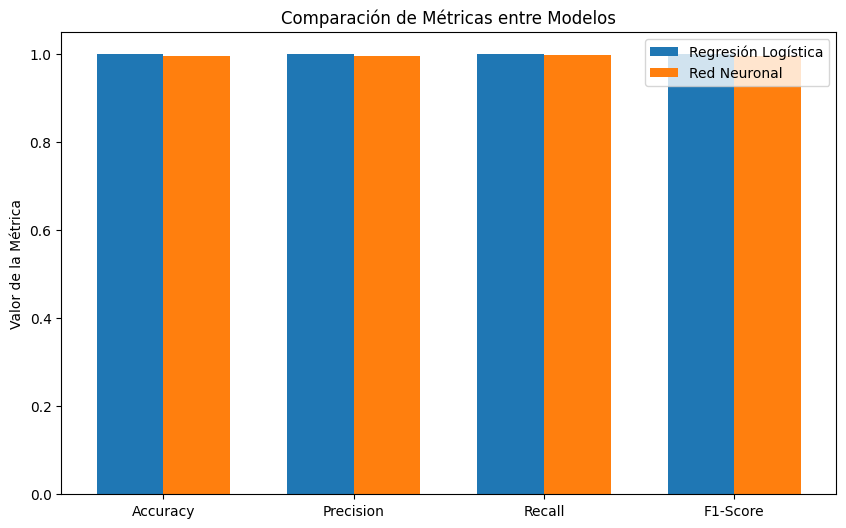

In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred_lr = model_lr.predict(X_test)
y_pred_nn_probs = model_nn.predict(X_test)
y_pred_nn = np.argmax(y_pred_nn_probs, axis=1)

# Calcular las métricas: Accuracy, Precision, Recall y F1-Score (promedio 'macro')
metrics_lr = {
    "Accuracy": accuracy_score(y_test, y_pred_lr),
    "Precision": precision_score(y_test, y_pred_lr, average='macro'),
    "Recall": recall_score(y_test, y_pred_lr, average='macro'),
    "F1-Score": f1_score(y_test, y_pred_lr, average='macro')
}
metrics_nn = {
    "Accuracy": accuracy_score(y_test, y_pred_nn),
    "Precision": precision_score(y_test, y_pred_nn, average='macro'),
    "Recall": recall_score(y_test, y_pred_nn, average='macro'),
    "F1-Score": f1_score(y_test, y_pred_nn, average='macro')
}

# Mostrar métricas en consola
print("\nMétricas de Regresión Logística:")
for key, value in metrics_lr.items():
    print(f"{key}: {value:.4f}")

print("\nMétricas de Red Neuronal:")
for key, value in metrics_nn.items():
    print(f"{key}: {value:.4f}")

# Graficar la comparación de métricas
metrics_names = list(metrics_lr.keys())
values_lr = [metrics_lr[m] for m in metrics_names]
values_nn = [metrics_nn[m] for m in metrics_names]

x = np.arange(len(metrics_names))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, values_lr, width=width, label='Regresión Logística')
plt.bar(x + width/2, values_nn, width=width, label='Red Neuronal')
plt.xticks(x, metrics_names)
plt.ylabel('Valor de la Métrica')
plt.title('Comparación de Métricas entre Modelos')
plt.legend()
plt.show()



                Feature  Importance  Importance_abs
0         MONTO_CREDITO  -14.343888       14.343888
1  MONTO_VALOR_VIVIENDA  -11.597353       11.597353
7             PROD_NCMV    2.655744        2.655744
8             PROD_NMIV    2.510117        2.510117
4   MONTO_CUOTA_INICIAL   -0.757822        0.757822
5             PROD_FCTP    0.128851        0.128851
3                  TASA    0.051336        0.051336
9            PROD_S-CRC    0.043635        0.043635
2                PLAZOS   -0.037579        0.037579
6       PROD_MT            0.000061        0.000061


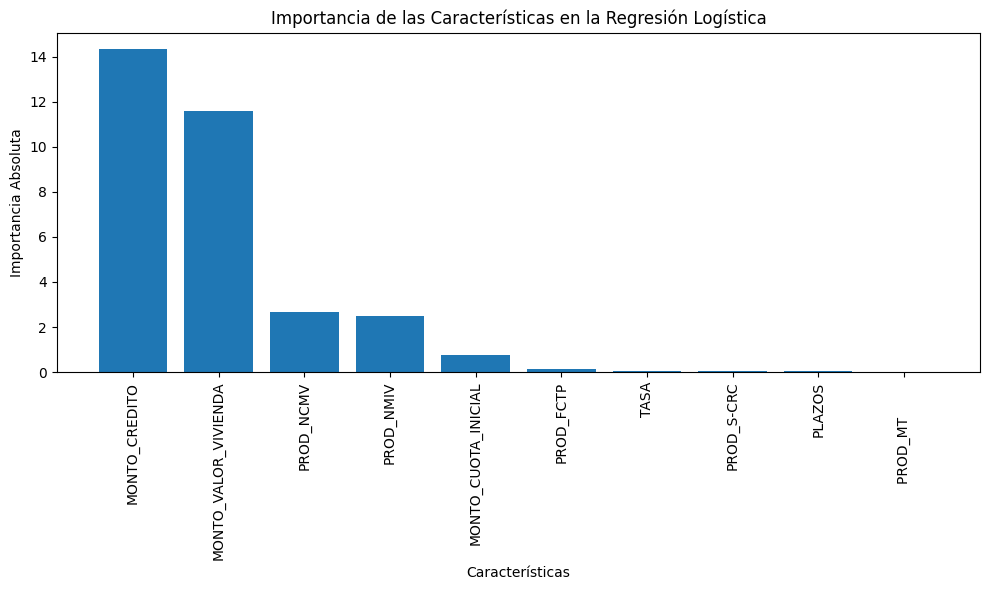

In [ ]:
def feature_importance_lr(model, feature_names):

    #Muestra la importancia de las características para un modelo de Regresión Logística.
    #Args:        model: El modelo de Regresión Logística entrenado.
    #feature_names: Una lista con los nombres de las características.

    importances = pd.DataFrame(data={
        'Feature': feature_names,
        'Importance': model.coef_[0]  # Coeficientes para la clase 0 (puedes ajustar si hay más clases)
    })
    importances['Importance_abs'] = importances['Importance'].abs()  # Valor absoluto para comparar
    importances = importances.sort_values(by=['Importance_abs'], ascending=False)

    print(importances)
    return importances


importances = feature_importance_lr(model_lr, X_train.columns)

# Crea la gráfica de barras
plt.figure(figsize=(10, 6))
plt.bar(importances['Feature'], importances['Importance_abs'])
plt.xticks(rotation=90)
plt.xlabel('Características')
plt.ylabel('Importancia Absoluta')
plt.title('Importancia de las Características en la Regresión Logística')
plt.tight_layout()
plt.show()

                Feature    Importance
1  MONTO_VALOR_VIVIENDA  3.147108e-06
0         MONTO_CREDITO  2.733511e-06
7             PROD_NCMV  8.623995e-07
8             PROD_NMIV  8.593415e-07
9            PROD_S-CRC  3.955828e-07
6       PROD_MT          1.317789e-07
5             PROD_FCTP  9.934109e-08
4   MONTO_CUOTA_INICIAL  9.362272e-08
2                PLAZOS  4.796719e-08
3                  TASA  1.686314e-08


Text(0, 0.5, 'Importancia')

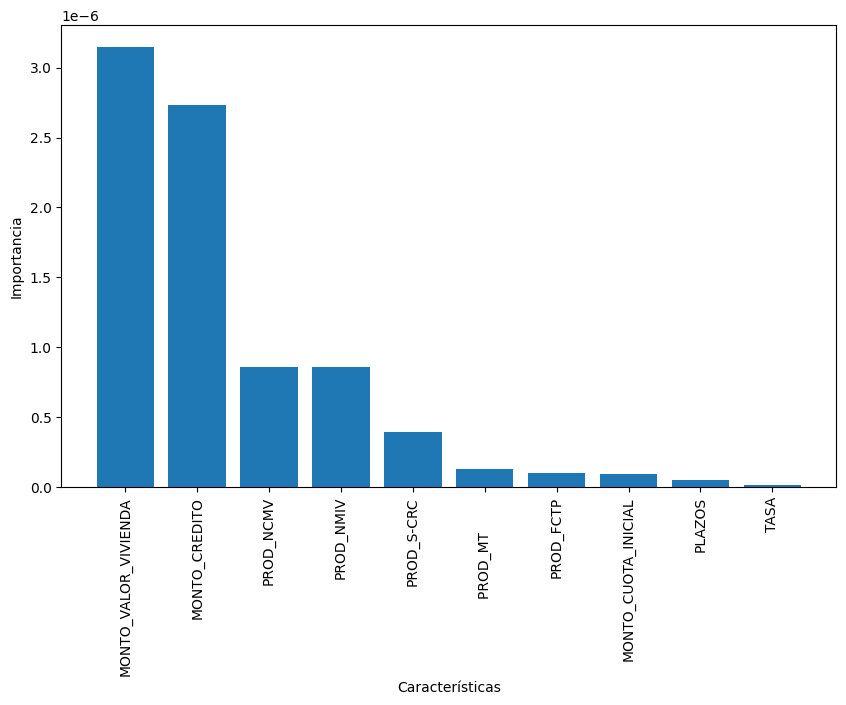

In [ ]:
import tensorflow as tf
import pandas as pd

def feature_importance_nn(model, X):
    #Calcula la importancia de las características para un modelo de Red Neuronal     usando gradientes.
    #Args:        model: El modelo de Red Neuronal entrenado.
    #X: Los datos de entrada (conjunto de prueba, por ejemplo).
    #Returns:   Un DataFrame con la importancia de las características.

    # Convertir el DataFrame de Pandas a un tensor de TensorFlow
    X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)

    # Calcula los gradientes de la salida con respecto a las entradas
    with tf.GradientTape() as tape:
        tape.watch(X_tensor)
        predictions = model(X_tensor)
    gradients = tape.gradient(predictions, X_tensor)

    # Calcula la importancia promedio de cada característica
    # tomando el valor absoluto promedio de los gradientes
    importances = tf.reduce_mean(tf.abs(gradients), axis=0).numpy()

    # Crea un DataFrame con la importancia de las características
    feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    feature_importances = feature_importances.sort_values(by=['Importance'], ascending=False)

    return feature_importances

# Calcula la importancia de las características
feature_importances = feature_importance_nn(model_nn, X_test)

# Muestra la importancia de las características
print(feature_importances)

# Graficar la importancia de las características
plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura si es necesario
plt.bar(feature_importances['Feature'], feature_importances['Importance'])
plt.xticks(rotation=90)  # Rota las etiquetas del eje x para mejor legibilidad
plt.xlabel('Características')
plt.ylabel('Importancia')

In [ ]:
#Predicción Manual con Nuevos Parámetros
def prediccion_manual(input_dict, UseDic):

    if UseDic == True:
        df_input = pd.DataFrame([input_dict])
    else:
      print("\n=== Predicción Manual ===")
      input_dict = {}
      # Solicitar valores numéricos
      for col in df_numeric.columns:
          while True:
              try:
                  val = float(input(f"Ingrese el valor para {col}: "))
                  input_dict[col] = val
                  break
              except ValueError:
                  print("Por favor, ingrese un número válido.")
      # Solicitar valor para "PRODUCTO"
      valor_producto = input("Ingrese el valor para PRODUCTO: ")
      input_dict["PRODUCTO"] = valor_producto
      #print("Dic input:",input_dict)
    # Crear DataFrame con la entrada del usuario
    df_input = pd.DataFrame([input_dict])

    # Procesar la parte numérica: escalado con el mismo scaler
    df_input_numeric = df_input[df_numeric.columns]
    df_input_numeric_scaled = scaler.transform(df_input_numeric)
    df_numeric_input = pd.DataFrame(df_input_numeric_scaled, columns=df_numeric.columns)

    # Procesar la parte categórica: One-Hot Encoding y reindexación para que coincida con el entrenamiento
    df_input_categorical = pd.get_dummies(df_input["PRODUCTO"], prefix="PROD")
    df_categorical_input = df_input_categorical.reindex(columns=dummy_columns, fill_value=0)

    # Combinar ambos conjuntos de variables
    input_features = pd.concat([df_numeric_input, df_categorical_input], axis=1)

    # Realizar la predicción con Regresión Logística
    pred_lr = model_lr.predict(input_features)[0]
    # Realizar la predicción con la Red Neuronal
    pred_nn_prob = model_nn.predict(input_features)[0]
    pred_nn = np.argmax(pred_nn_prob)

    # Convertir los índices de predicción a las etiquetas originales
    label_lr = le.inverse_transform([pred_lr])[0]
    label_nn = le.inverse_transform([pred_nn])[0]


    print("\nResultados de la Predicción Manual:")
    #print("-> Predicción con Regresión Logística:", label_lr)
    #print("-> Predicción con Red Neuronal:", label_nn)

    #___________________________ Interpretacion de resultado_________
    if label_nn == 0:
      print("\nPertenece al segmento de BAJOS INGRESOS: (0)")
    else:
      print("\nPertenece al segmento de ALTOS INGRESOS: (1)")

# Para probar la predicción manual, con datos predefinidos e individuales
DicColumnas={'MONTO_CREDITO': 430000, #MONTO_CREDITO de: 10600 hasta 431370
             'MONTO_VALOR_VIVIENDA': 479000, #MONTO_VALOR_VIVIENDA de: 63312 - 479300
             'PLAZOS': 300, #PLAZOS de: 14 hasta 300
             'TASA': 9, #TASA de: 5 hasta 23
             'MONTO_CUOTA_INICIAL': 3100, #De 2300 hasta 318744
             'PRODUCTO': 'FCTP' #Tipo Producto son: NMIV, FCTP, S-CRC
             }

prediccion_manual(DicColumnas, True) #Predice segmento economico

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Resultados de la Predicción Manual:

Pertenece al segmento de BAJOS INGRESOS: (0)
